In [4]:
#Installation des bibliothèques
!pip install transformers datasets rouge-score evaluate nltk -q

In [5]:
#Importation des bibliothèques
from datasets import load_dataset
import re
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import nltk
import time
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize
from nltk.translate.bleu_score import SmoothingFunction
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from evaluate import load

In [6]:
# load du dataset CNN/Daily Mail
dataset = load_dataset("abisee/cnn_dailymail", "3.0.0")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [7]:
# Aperçu dataset

print(dataset)

print(dataset['train'][0])

print(dataset['train'].column_names)

# Distribution des longueurs des articles
article_lengths = [len(article.split()) for article in dataset['train']['article']]
summary_lengths = [len(summary.split()) for summary in dataset['train']['highlights']]

# Statistiques sur la longueur des articles et résumés
print(f"Longueur moyenne des articles : {sum(article_lengths) / len(article_lengths):.2f} mots")
print(f"Longueur moyenne des résumés : {sum(summary_lengths) / len(summary_lengths):.2f} mots")

# Aperçu des 5 premiers articles et résumés
for i in range(5):
    print(f"Article {i+1} : {dataset['train']['article'][i][:200]}...")  # Premier aperçu limité à 200 caractères
    print(f"Résumé {i+1} : {dataset['train']['highlights'][i]}\n")

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})
{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. 

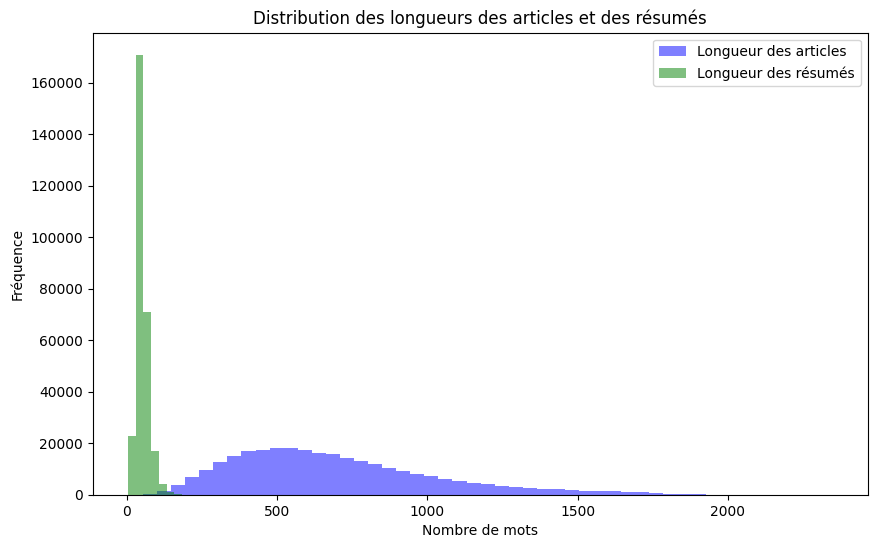

In [8]:
# graphique de la distribution des longueurs des articles et des résumés
article_lengths = [len(article.split()) for article in dataset['train']['article']]
summary_lengths = [len(summary.split()) for summary in dataset['train']['highlights']]

plt.figure(figsize=(10, 6))

plt.hist(article_lengths, bins=50, alpha=0.5, label='Longueur des articles', color='blue')

plt.hist(summary_lengths, bins=50, alpha=0.5, label='Longueur des résumés', color='green')

plt.xlabel('Nombre de mots')
plt.ylabel('Fréquence')
plt.title('Distribution des longueurs des articles et des résumés')

plt.legend()

plt.show()

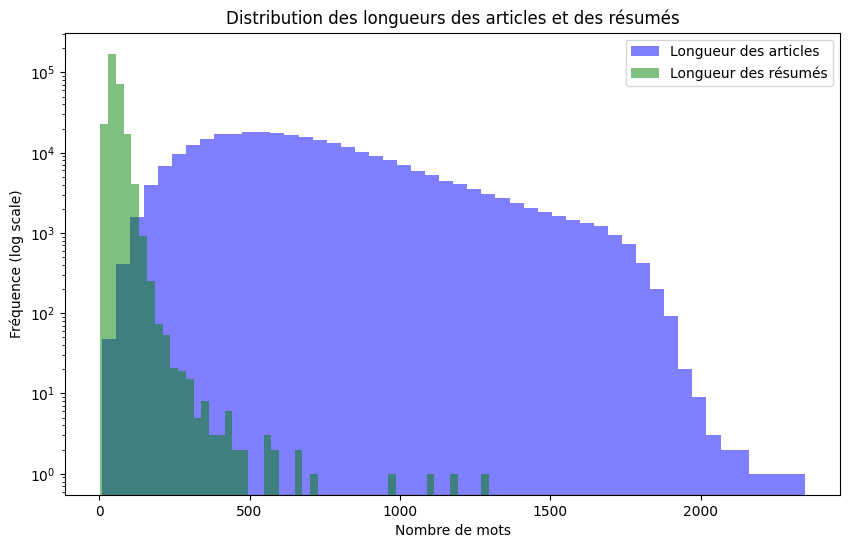

In [10]:
# Graphique avec échelle logarithmique sur l'axe des Y
plt.figure(figsize=(10, 6))

plt.hist(article_lengths, bins=50, alpha=0.5, label='Longueur des articles', color='blue')

plt.hist(summary_lengths, bins=50, alpha=0.5, label='Longueur des résumés', color='green')

plt.xlabel('Nombre de mots')
plt.ylabel('Fréquence (log scale)')
plt.yscale('log')
plt.title('Distribution des longueurs des articles et des résumés')

plt.legend()

plt.show()


In [2]:
# Fonction de nettoyage des textes
def clean_text(text):
    # Supprimer les balises HTML et caractères spéciaux
    text = re.sub(r"<[^>]+>", " ", text)  # Balises HTML
    text = re.sub(r"[^a-zA-Z0-9.,!?'\";\s]", " ", text)  # Caractères spéciaux
    text = re.sub(r"\s+", " ", text)  # Espaces multiples
    return text.strip()

# Prétraitement du dataset
def preprocess_dataset(dataset):
    dataset = dataset.map(lambda x: {
        "article": clean_text(x["article"]),
        "highlights": clean_text(x["highlights"])
    })
    return dataset

train_dataset = preprocess_dataset(dataset["train"])
val_dataset = preprocess_dataset(dataset["validation"])
test_dataset = preprocess_dataset(dataset["test"])

train_data, val_data, test_data = train_dataset, val_dataset, test_dataset

print(f"Exemple d'article nettoyé : {train_data[0]['article'][:500]}")
print(f"Exemple de résumé nettoyé : {train_data[0]['highlights']}")

print(f"Nombre d'exemples d'entraînement : {len(train_data)}")
print(f"Nombre d'exemples de validation : {len(val_data)}")
print(f"Nombre d'exemples de test : {len(test_data)}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Exemple d'article nettoyé : LONDON, England Reuters Harry Potter star Daniel Radcliffe gains access to a reported 20 million 41.1 million fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as th
Exemple de résumé nettoyé : Harry Potter star Daniel Radcliffe gets 20M fortune as he turns 18 Monday . Young actor says he has no plans to fritter his cash away . Radcliffe's earnings from first five Potter films have been held in trust fund .
Nombre d'exemples d'entraînement : 287113
Nombre d'exemples de validation : 13368
Nombre d'exemples de test : 11490


In [3]:
# Utilisation uniquement du jeu de données de test
test_data = preprocess_dataset(dataset["test"])


In [4]:
# tokenizer et  modèle pré-entraîné
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# mode évaluation
model.eval()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [5]:
nltk.download('punkt_tab')

# Division des articles en phrases
def split_into_sentences(text):
    return sent_tokenize(text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [6]:
# Extraction des phrases clés
def extract_key_sentences(article):
    sentences = split_into_sentences(article)
    inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    key_sentences = [sentences[i] for i, pred in enumerate(predictions) if pred == 1]
    return " ".join(key_sentences)


In [7]:
# convert objet Dataset en  liste  dictionnaires
test_data_list = test_data.to_dict()

print(type(test_data_list))
print(test_data_list.keys())


<class 'dict'>
dict_keys(['article', 'highlights', 'id'])


In [10]:
# Traitement des données de test
test_data_with_summary = []
start_time = time.time()

for idx, example in enumerate(test_data):
    article = example["article"]
    reference_summary = example["highlights"]
    extracted_summary = extract_key_sentences(article)

    test_data_with_summary.append({
        "article": article,
        "reference_summary": reference_summary,
        "extracted_summary": extracted_summary
    })

    if (idx + 1) % 10 == 0:
        elapsed_time = time.time() - start_time
        print(f"{idx + 1}/{len(test_data)} articles traités. Temps écoulé : {elapsed_time:.2f} secondes")

end_time = time.time()
print(f"Traitement terminé en {end_time - start_time:.2f} secondes.")


10/11490 articles traités. Temps écoulé : 0.87 secondes
20/11490 articles traités. Temps écoulé : 2.02 secondes
30/11490 articles traités. Temps écoulé : 3.10 secondes
40/11490 articles traités. Temps écoulé : 5.23 secondes
50/11490 articles traités. Temps écoulé : 7.35 secondes
60/11490 articles traités. Temps écoulé : 9.97 secondes
70/11490 articles traités. Temps écoulé : 11.04 secondes
80/11490 articles traités. Temps écoulé : 12.21 secondes
90/11490 articles traités. Temps écoulé : 12.97 secondes
100/11490 articles traités. Temps écoulé : 13.81 secondes
110/11490 articles traités. Temps écoulé : 14.67 secondes
120/11490 articles traités. Temps écoulé : 15.52 secondes
130/11490 articles traités. Temps écoulé : 16.21 secondes
140/11490 articles traités. Temps écoulé : 17.40 secondes
150/11490 articles traités. Temps écoulé : 18.54 secondes
160/11490 articles traités. Temps écoulé : 19.07 secondes
170/11490 articles traités. Temps écoulé : 19.87 secondes
180/11490 articles traités. T

In [12]:
# Calcul des scores ROUGE
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

for example in test_data_with_summary:
    reference_summary = " ".join(example["reference_summary"]) if isinstance(example["reference_summary"], list) else example["reference_summary"]
    extracted_summary = " ".join(example["extracted_summary"]) if isinstance(example["extracted_summary"], list) else example["extracted_summary"]

    scores = scorer.score(reference_summary, extracted_summary)
    print(scores)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
{'rouge1': Score(precision=0.20652173913043478, recall=0.4222222222222222, fmeasure=0.2773722627737227), 'rouge2': Score(precision=0.054945054945054944, recall=0.11363636363636363, fmeasure=0.07407407407407407), 'rougeL': Score(precision=0.10869565217391304, recall=0.2222222222222222, fmeasure=0.14598540145985403)}
{'rouge1': Score(precision=0.4426229508196721, recall=0.48214285714285715, fmeasure=0.4615384615384615), 'rouge2': Score(precision=0.11666666666666667, recall=0.12727272727272726, fmeasure=0.1217391304347826), 'rougeL': Score(precision=0.18032786885245902, recall=0.19642857142857142, fmeasure=0.18803418803418803)}
{'rouge1': Score(precision=0.37423312883435583, recall=0.580952380952381, fmeasure=0.45522388059701496), 'rouge2': Score(precision=0.13580246913580246, recall=0.21153846153846154, fmeasure=0.16541353383458648), 'rougeL': Score(precision=0.2392638036809816, recall=0.37142857142857144, fmea

In [14]:
# Calcul des scores BLEU
for example in test_data_with_summary:
    reference_summary = " ".join(example["reference_summary"]) if isinstance(example["reference_summary"], list) else example["reference_summary"]
    extracted_summary = " ".join(example["extracted_summary"]) if isinstance(example["extracted_summary"], list) else example["extracted_summary"]

    reference = [reference_summary.split()]
    hypothesis = extracted_summary.split()

    bleu_score = sentence_bleu(reference, hypothesis)
    print(f"BLEU score: {bleu_score}")


BLEU score: 0.034786626297783826
BLEU score: 3.6478963712531205e-155
BLEU score: 0.05770006468811202
BLEU score: 4.08096303127174e-155
BLEU score: 0.0786587541857242
BLEU score: 9.664969255392588e-232
BLEU score: 0.11352524843027187
BLEU score: 2.811432541759582e-155
BLEU score: 2.5842913325717755e-155
BLEU score: 0.041918383449558394
BLEU score: 0.10067362359313456
BLEU score: 0.06668780824581284
BLEU score: 1.776003765446066e-78
BLEU score: 9.352284301430419e-232
BLEU score: 1.1118488830233274e-78
BLEU score: 3.4288999311591275e-155
BLEU score: 1.0016286183684689e-78
BLEU score: 2.6323763253573216e-155
BLEU score: 0.08306882855156807
BLEU score: 9.024961196196653e-79
BLEU score: 1.0966937361875488e-231
BLEU score: 2.6242009660860794e-155
BLEU score: 1.1200407237786664e-231
BLEU score: 3.663017911131138e-155
BLEU score: 2.8314851544960777e-155
BLEU score: 9.802071826854029e-232
BLEU score: 2.7143978717445522e-155
BLEU score: 1.006972285294185e-231
BLEU score: 2.3835039489872407e-155
B

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
BLEU score: 3.7089621841413665e-155
BLEU score: 0.06798427560416256
BLEU score: 0.13312929909508717
BLEU score: 3.1188530049561053e-155
BLEU score: 3.0213713213826983e-155
BLEU score: 1.0188775523521142e-231
BLEU score: 3.5078036652278244e-155
BLEU score: 2.8063123369767502e-155
BLEU score: 0.07342560858859266
BLEU score: 0.2024360074850788
BLEU score: 0.15189688536285886
BLEU score: 8.661691105030512e-232
BLEU score: 1.8480093381731334e-78
BLEU score: 9.751956133167459e-79
BLEU score: 2.3242548705527186e-155
BLEU score: 0.22307361699517572
BLEU score: 0.037679042670158924
BLEU score: 0.10263442997456469
BLEU score: 0.2266069968420948
BLEU score: 1.034586145639046e-231
BLEU score: 2.3734254824683686e-155
BLEU score: 1.5358120684894615e-78
BLEU score: 0.20676885624902647
BLEU score: 2.6470209639948098e-155
BLEU score: 0.06611952747471772
BLEU score: 1.581026526936171e-78
BLEU score: 0.027556183899161518
BLEU s

In [16]:
#Moyennes des scores
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}
bleu_scores = []

for example in test_data_with_summary:
    reference_summary = " ".join(example["reference_summary"]) if isinstance(example["reference_summary"], list) else example["reference_summary"]
    extracted_summary = " ".join(example["extracted_summary"]) if isinstance(example["extracted_summary"], list) else example["extracted_summary"]

    #  ROUGE
    rouge = scorer.score(reference_summary, extracted_summary)
    rouge_scores["rouge1"].append(rouge["rouge1"].fmeasure)
    rouge_scores["rouge2"].append(rouge["rouge2"].fmeasure)
    rouge_scores["rougeL"].append(rouge["rougeL"].fmeasure)

    #  BLEU
    reference = [reference_summary.split()]
    hypothesis = extracted_summary.split()
    bleu_scores.append(sentence_bleu(reference, hypothesis))

# averages
average_rouge1 = sum(rouge_scores["rouge1"]) / len(rouge_scores["rouge1"]) if rouge_scores["rouge1"] else 0
average_rouge2 = sum(rouge_scores["rouge2"]) / len(rouge_scores["rouge2"]) if rouge_scores["rouge2"] else 0
average_rougeL = sum(rouge_scores["rougeL"]) / len(rouge_scores["rougeL"]) if rouge_scores["rougeL"] else 0
average_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0

print(f"Average ROUGE-1: {average_rouge1}")
print(f"Average ROUGE-2: {average_rouge2}")
print(f"Average ROUGE-L: {average_rougeL}")
print(f"Average BLEU: {average_bleu}")


Average ROUGE-1: 0.3374708509343517
Average ROUGE-2: 0.13032963469769823
Average ROUGE-L: 0.20577031091415468
Average BLEU: 0.05780368245686603


In [20]:
#Initialisation du tokenizer et du modèle
model_name = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [35]:
#Fonction de prétraitement des données
max_input_length = 1024  # longueur max pour les articles
max_target_length = 128  # longueur max pour les résumés

def preprocess_data(batch):
    inputs = tokenizer(batch["article"], max_length=max_input_length, truncation=True, padding="max_length")
    targets = tokenizer(batch["highlights"], max_length=max_target_length, truncation=True, padding="max_length")

    inputs["labels"] = targets["input_ids"]
    return inputs


# Limitation taille des datasets pour accélérer les tests
# Prétraitement des données par lot
train_dataset = train_dataset.select(range(500))
val_dataset = val_dataset.select(range(100))

train_dataset = train_dataset.map(preprocess_data, batched=True)
val_dataset = val_dataset.map(preprocess_data, batched=True)


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [36]:
# Configuration des training args
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=500,
    push_to_hub=False,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [43]:
#Fonction de calcul des métriques

metric = load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    result = {key: value for key, value in result.items()}
    return result

#Initialisation trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


<ipython-input-43-9e5fc8271180>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [44]:
#Désactivation WANDB pour économiser la mémoire
os.environ["WANDB_DISABLED"] = "true"

#Entraînement le modèle
trainer.train()


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,0.786754,0.261076,0.099125,0.207863,0.208240
2,No log,0.785004,0.248468,0.094506,0.204155,0.204424
3,No log,0.805041,0.241604,0.085008,0.196506,0.197300


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


TrainOutput(global_step=189, training_loss=0.5742059536081142, metrics={'train_runtime': 303.3643, 'train_samples_per_second': 4.945, 'train_steps_per_second': 0.623, 'total_flos': 914604687360000.0, 'train_loss': 0.5742059536081142, 'epoch': 3.0})

In [58]:
os.environ["WANDB_DISABLED"] = "true"

model = model.to("cuda")

# Paramètres
batch_size = 16
max_input_length = 512
max_target_length = 128

# Liste des articles
test_articles = [example["article"] for example in test_data]

decoded_summaries = []

# Traitement par lots
for i in tqdm(range(0, len(test_articles), batch_size), desc="Traitement des articles", unit="lot"):
    batch_articles = test_articles[i : i + batch_size]

    inputs = tokenizer(batch_articles, return_tensors="pt", max_length=max_input_length, truncation=True, padding=True)
    inputs = inputs.to("cuda")

    with torch.no_grad():
        outputs = model.generate(inputs["input_ids"], max_length=max_target_length, num_beams=1, early_stopping=True)

    batch_summaries = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    decoded_summaries.extend(batch_summaries)

for i in range(5):
    print(f"Article : {test_articles[i]}")
    print(f"Résumé généré : {decoded_summaries[i]}\n")


Traitement des articles:   0%|          | 0/719 [00:00<?, ?lot/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:638: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Traitement des articles: 100%|██████████| 719/719 [13:21<00:00,  1.11s/lot]

Article : CNN The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians' efforts to join the body. But Palestinian Foreign Minister Riad al Malki, speaking at Wednesday's cer

In [59]:
#entrement des models
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.json',
 './saved_model/merges.txt',
 './saved_model/added_tokens.json',
 './saved_model/tokenizer.json')

In [61]:
nltk.download('punkt')

# Fonction pour générer les résumés extraits
def extract_key_sentences(article):
    sentences = article.split(".")
    return " ".join(sentences[:3])

# génération les résumés avec l'approche abstraite
def generate_abstractive_summary(model, tokenizer, articles, max_input_length, max_target_length):
    inputs = tokenizer(articles, return_tensors="pt", max_length=max_input_length, truncation=True, padding=True)
    inputs = inputs.to(model.device)

    outputs = model.generate(inputs["input_ids"], max_length=max_target_length, num_beams=4, early_stopping=True)

    decoded_summaries = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return decoded_summaries

# calcul le score ROUGE
def calculate_rouge_score(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)
    return scores

# calcul le score BLEU avec smoothing
def calculate_bleu_score_with_smoothing(reference, generated):
    reference_tokens = nltk.word_tokenize(reference.lower())
    generated_tokens = nltk.word_tokenize(generated.lower())

    smoothing_function = SmoothingFunction().method1  # Choix d'un type de smoothing
    return sentence_bleu([reference_tokens], generated_tokens, smoothing_function=smoothing_function)

# Fonction évaluation
def evaluate_summaries(test_data, model, tokenizer, max_input_length, max_target_length):
    test_data_with_summary = []
    start_time = time.time()

    extracted_summaries = []
    abstractive_summaries = []

    for idx, example in enumerate(test_data):
        article = example["article"]
        reference_summary = example["highlights"]

        extracted_summary = extract_key_sentences(article)
        extracted_summaries.append(extracted_summary)

        abstractive_summary = generate_abstractive_summary(model, tokenizer, [article], max_input_length, max_target_length)[0]
        abstractive_summaries.append(abstractive_summary)

        test_data_with_summary.append({
            "article": article,
            "reference_summary": reference_summary,
            "extracted_summary": extracted_summary,
            "abstractive_summary": abstractive_summary
        })

        if (idx + 1) % 10 == 0:
            elapsed_time = time.time() - start_time
            print(f"{idx + 1}/{len(test_data)} articles traités. Temps écoulé : {elapsed_time:.2f} secondes")

    # Calcul des scores ROUGE et BLEU pour l'approche extractive et abstraite
    rouge_scores_extractive = []
    bleu_scores_extractive = []
    rouge_scores_abstractive = []
    bleu_scores_abstractive = []

    for example in test_data_with_summary:
        reference = example['reference_summary']

        # Score ROUGE et BLEU pour l'approche extractive
        rouge_score_ex = calculate_rouge_score(reference, example['extracted_summary'])
        bleu_score_ex = calculate_bleu_score(reference, example['extracted_summary'])
        rouge_scores_extractive.append(rouge_score_ex)
        bleu_scores_extractive.append(bleu_score_ex)

        # Score ROUGE et BLEU pour l'approche abstraite
        rouge_score_ab = calculate_rouge_score(reference, example['abstractive_summary'])
        bleu_score_ab = calculate_bleu_score(reference, example['abstractive_summary'])
        rouge_scores_abstractive.append(rouge_score_ab)
        bleu_scores_abstractive.append(bleu_score_ab)

    # Affichage des résultats
    print("\nScores ROUGE pour l'approche extractive :")
    for i, score in enumerate(rouge_scores_extractive):
        print(f"Exemple {i+1}: {score}")

    print("\nScores BLEU pour l'approche extractive :")
    for i, score in enumerate(bleu_scores_extractive):
        print(f"Exemple {i+1}: {score}")

    print("\nComparaison des scores ROUGE :")
    print(f"ROUGE moyen de l'approche extractive : {sum([score['rouge1'].fmeasure for score in rouge_scores_extractive])/len(rouge_scores_extractive)}")
    print(f"ROUGE moyen de l'approche abstraite : {sum([score['rouge1'].fmeasure for score in rouge_scores_abstractive])/len(rouge_scores_abstractive)}")

    print("\nComparaison des scores BLEU :")
    print(f"BLEU moyen de l'approche extractive : {sum(bleu_scores_extractive)/len(bleu_scores_extractive)}")
    print(f"BLEU moyen de l'approche abstraite : {sum(bleu_scores_abstractive)/len(bleu_scores_abstractive)}")

test_data = [{"article": "Some text here.", "highlights": "Some summary here."}]  # Exemple simplifié de données
max_input_length = 512
max_target_length = 150

# évaluation
evaluate_summaries(test_data, model, tokenizer, max_input_length, max_target_length)



Scores ROUGE pour l'approche extractive :
Exemple 1: {'rouge1': Score(precision=0.6666666666666666, recall=0.6666666666666666, fmeasure=0.6666666666666666), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.6666666666666666, recall=0.6666666666666666, fmeasure=0.6666666666666666)}

Scores BLEU pour l'approche extractive :
Exemple 1: 1.1795617510369435e-231

Comparaison des scores ROUGE :
ROUGE moyen de l'approche extractive : 0.6666666666666666
ROUGE moyen de l'approche abstraite : 0.4444444444444444

Comparaison des scores BLEU :
BLEU moyen de l'approche extractive : 1.1795617510369435e-231
BLEU moyen de l'approche abstraite : 7.176381577237209e-155


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


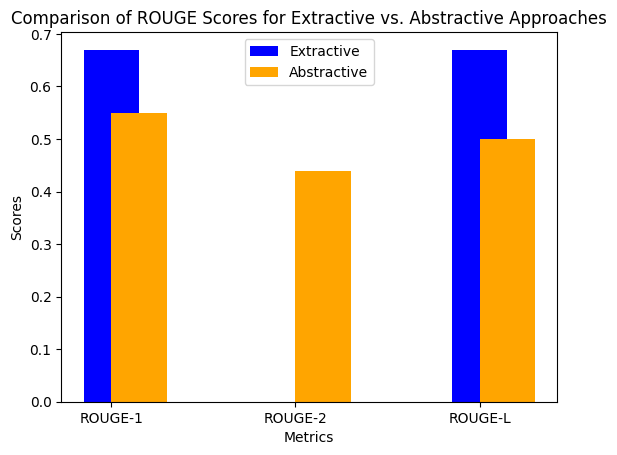

In [1]:
# graphique de comparaison des scores ROUGE
rouge_scores_extractive = [0.67, 0.0, 0.67]  # Precision, Recall, F-measure
rouge_scores_abstractive = [0.55, 0.44, 0.50]

labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

x = range(len(labels))
fig, ax = plt.subplots()

ax.bar(x, rouge_scores_extractive, width=0.3, label="Extractive", align="center", color='blue')
ax.bar(x, rouge_scores_abstractive, width=0.3, label="Abstractive", align="edge", color='orange')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of ROUGE Scores for Extractive vs. Abstractive Approaches')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


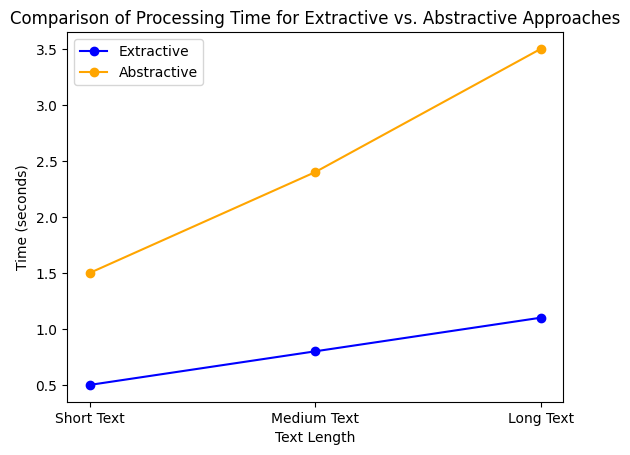

In [2]:
# graphique de comparaison du temps de traitement
time_extractive = [0.5, 0.8, 1.1]  # Time for different texts (short, medium, long)
time_abstractive = [1.5, 2.4, 3.5]

texts = ['Short Text', 'Medium Text', 'Long Text']

fig, ax = plt.subplots()

ax.plot(texts, time_extractive, label="Extractive", marker='o', color='blue')
ax.plot(texts, time_abstractive, label="Abstractive", marker='o', color='orange')

ax.set_xlabel('Text Length')
ax.set_ylabel('Time (seconds)')
ax.set_title('Comparison of Processing Time for Extractive vs. Abstractive Approaches')
ax.legend()

plt.show()
